<a href="https://colab.research.google.com/github/xuziyue/tensorflow-models/blob/main/cnn_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf '/root/.keras/datasets/flower_photos'

In [2]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from absl import logging
logging.set_verbosity(logging.ERROR)

In [5]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(origin=_URL, fname="flower_photos.tgz", extract=True)

228818944/228813984 [==============================] - 3s 0us/step


In [6]:
base_dir = os.path.join(os.path.dirname(zip_file), "flower_photos")

In [7]:
!find $base_dir -type d -print

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/daisy


In [8]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [9]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [10]:
!find $base_dir -type d -print

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/val
/root/.keras/datasets/flower_photos/val/roses
/root/.keras/datasets/flower_photos/val/dandelion
/root/.keras/datasets/flower_photos/val/tulips
/root/.keras/datasets/flower_photos/val/sunflowers
/root/.keras/datasets/flower_photos/val/daisy
/root/.keras/datasets/flower_photos/train
/root/.keras/datasets/flower_photos/train/roses
/root/.keras/datasets/flower_photos/train/dandelion
/root/.keras/datasets/flower_photos/train/tulips
/root/.keras/datasets/flower_photos/train/sunflowers
/root/.keras/datasets/flower_photos/train/daisy
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/daisy


In [11]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [12]:
batch_size = 100
IMG_SHAPE = 150

In [13]:
image_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               rotation_range=45,
                               zoom_range=0.5,
                               width_shift_range=0.15,
                               height_shift_range=0.15)

train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        target_size=(IMG_SHAPE, IMG_SHAPE),
                                                        class_mode='sparse')

Found 2935 images belonging to 5 classes.


In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [15]:
# Labels are sparse, not categorical one-hot vector
train_data_gen[0][1]

array([3., 1., 1., 0., 1., 4., 1., 0., 1., 4., 1., 4., 3., 0., 1., 4., 1.,
       2., 1., 3., 0., 2., 2., 1., 1., 0., 4., 0., 2., 1., 4., 2., 0., 4.,
       0., 4., 1., 1., 1., 1., 4., 4., 4., 1., 2., 4., 1., 4., 1., 4., 3.,
       2., 3., 4., 0., 0., 2., 4., 3., 3., 1., 1., 1., 4., 2., 0., 4., 2.,
       0., 0., 3., 0., 3., 2., 4., 0., 4., 0., 3., 3., 1., 3., 1., 0., 4.,
       4., 4., 0., 1., 0., 4., 1., 3., 1., 4., 4., 3., 3., 4., 2.],
      dtype=float32)

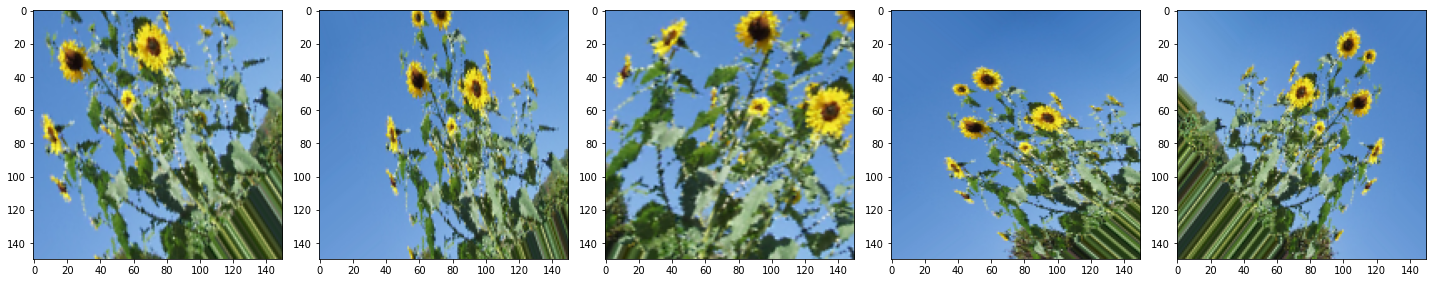

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [17]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(directory=val_dir,
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


In [18]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
          tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(5, activation='softmax')])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# epochs = 80
# history = model.fit_generator(train_data_gen,
#                               steps_per_epoch=int(np.ceil(train_data_gen.n/float(batch_size))),
#                               epochs=epochs,
#                               validation_data=val_data_gen,
#                               validation_steps=int(np.ceil(val_data_gen.n/float(batch_size))))
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


30/30 [==============================] - 56s 877ms/step - loss: 1.5905 - accuracy: 0.3070 - val_loss: 1.2880 - val_accuracy: 0.4476
Epoch 2/80
30/30 [==============================] - 26s 870ms/step - loss: 1.1707 - accuracy: 0.4934 - val_loss: 1.1254 - val_accuracy: 0.5810
Epoch 3/80
30/30 [==============================] - 26s 878ms/step - loss: 1.0658 - accuracy: 0.5697 - val_loss: 1.1090 - val_accuracy: 0.5592
Epoch 4/80
30/30 [==============================] - 26s 878ms/step - loss: 0.9918 - accuracy: 0.6078 - val_loss: 1.0455 - val_accuracy: 0.6150
Epoch 5/80
30/30 [==============================] - 26s 880ms/step - loss: 0.9559 - accuracy: 0.6239 - val_loss: 0.9455 - val_accuracy: 0.6517
Epoch 6/80
30/30 [==============================] - 26s 880ms/step - loss: 0.9201 - accuracy: 0.6412 - val_loss: 0.8892 - val_accuracy: 0.6748
Epoch 7/80
30/30 [==============================] - 26s 893ms/step - loss: 0.9001 - accuracy: 0.6504 - val_loss: 0.8687 - val_accuracy: 0.6898
Epoch 8/80

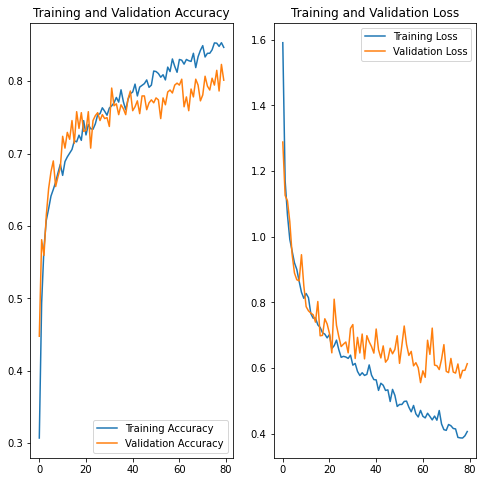

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()